<h1>Baseline performance High resolution</h1>

# Title

## Abstract

## Introduction

## Relevant theory

## Method

## Results and discuccion

## Conclusion

In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os

sys.path.append("../../")

import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob
import pandas as pd

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.OriginalMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me
###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:
sys.path.append("../../")

ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_001-EXP_002-Baseline_H_res"

INIT_METHOD = "original"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "900X750"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE="H"
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising the results

['im2.ppm', 'im6.ppm', 'disp2.pgm', 'teddy_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\teddyH\im2.ppm
..\..\datasets\middlebury\middlebury_2003\teddyH\im6.ppm
..\..\datasets\middlebury\middlebury_2003\teddyH\disp2.pgm
..\..\datasets\middlebury\middlebury_2003\teddyH\teddy_nonocc.png
['im2.ppm', 'im6.ppm', 'disp2.pgm', 'cones_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\conesH\im2.ppm
..\..\datasets\middlebury\middlebury_2003\conesH\im6.ppm
..\..\datasets\middlebury\middlebury_2003\conesH\disp2.pgm
..\..\datasets\middlebury\middlebury_2003\conesH\cones_nonocc.png


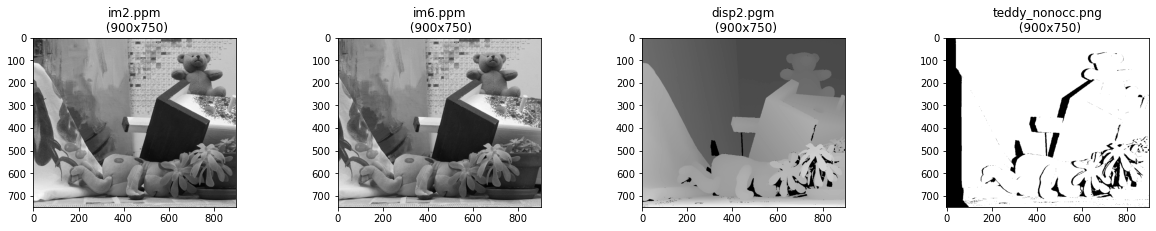

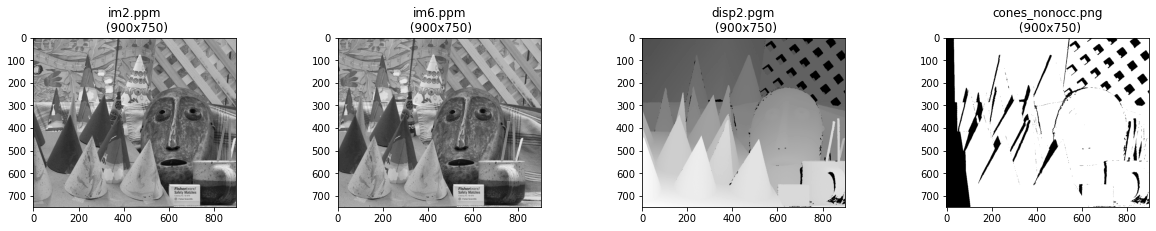

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene, size=SIZE) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# The addition of occluded areas to the pristine groundtruth images

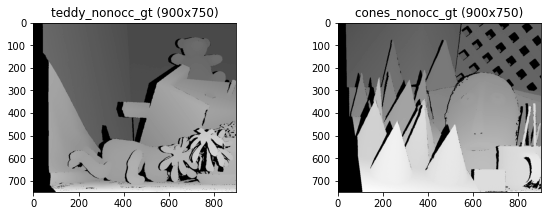

In [4]:
###################################################################
# 2. Occluded areas are added to the groundtruths #################
###################################################################

nonocc_gts = list()
for imgs, paths in loaded_imgs_and_paths:
    temp = mbu.add_masks_to_raw_disparity(imgs[2], imgs[3])
    nonocc_gts.append(mbu.add_masks_to_raw_disparity(imgs[2], imgs[3]))
plu.plot_images(nonocc_gts, ["teddy_nonocc_gt", "cones_nonocc_gt"])

# Benchmarking and evaluation

In [5]:
###################################################################
# 3.1 Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 60
GAP = -20
EGAP = -1


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET+SIZE,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

Directory '..\..\experiments\logs' already exists.

In [ ]:
###################################################################
# 3.2 Matching ####################################################
###################################################################

results = []
init_functions = [[m.fillUpFirstRows, "default"], [m.fillUpFirstRows2, "gap*col_i"], [m.fillUpFirstRows3, "gap*col"]]

for init_function in init_functions:
    matcher = m(MATCH, GAP, EGAP, first_rows_fill_func = init_function[0])
    EXP_PARAMS["init_method"] = init_function[1]
    for i, scene in enumerate(SCENES):
        EXP_PARAMS["scene"] = scene
        EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
        EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
        occ = loaded_imgs_and_paths[i][0][3]
        gt = loaded_imgs_and_paths[i][0][2]
        matcher.initialize(loaded_imgs_and_paths[i][0][0], loaded_imgs_and_paths[i][0][1])
        tic = time.time()
        matcher.alignImages()
        toc=time.time()
        EXP_PARAMS["runtime"] = toc-tic
        
        disp = matcher.lastDisparity
        #disp = disp*4
        EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = True
        EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
        BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

        csv_logger.append_new_sm_results(EXP_PARAMS, csv.get_header_v3())

        EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False
        EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
        BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

        csv_logger.append_new_sm_results(EXP_PARAMS, csv.get_header_v3())
        results.append(disp)

750
Matcher has been initialized.
750
Matcher has been initialized.
750
Matcher has been initialized.
750
Matcher has been initialized.
750
Matcher has been initialized.
750
Matcher has been initialized.


In [ ]:
SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)
saved_image_names = []
for result in results:
    temp_path = u.save_disparity(SAVE_PATH, result)
    saved_image_names.append(os.path.split(temp_path)[-1])

In [ ]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad1", inplace=True) 
experiment_log.head(8)